# Transfer Learning

A Convolutional Neural Network (CNN) for image classification is made up of multiple layers that extract features, such as edges, corners, etc; and then use a final fully-connected layer to classify objects based on these features. You can visualize this like this:

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*Transfer Learning* is a technique where you can take an existing trained model and re-use its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, your model benefits from the feature extraction training that was performed on the base model (which may have been based on a larger training dataset than you have access to) to build a classification model for your own specific set of object classes.

How does this help? Well, think of it this way. Suppose you take a professional tennis player and a complete beginner, and try to teach them both how to play raquetball. It's reasonable to assume that the professional tennis player will be easier to train, because many of the underlying skills involved in raquetball are already learned. Similarly, a pre-trained CNN model may be easier to train to classify specific set of objects because it's already learned how to identify the features of common objects, such as edges and corners. Fundamentally, a pre-trained model can be a great way to produce an effective classifier even when you have limited data with which to train it.

In this notebook, we'll see how to implement transfer learning for a classification model using TensorFlow.

## Install and import TensorFlow libraries

Let's start by ensuring that we have the latest version of the **TensorFlow** package installed and importing the Tensorflow libraries we're going to use.

In [1]:
# !pip install --upgrade tensorflow

In [2]:
import tensorflow as tf
import keras
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.8.0


## Prepare the base model

To use transfer learning, we need a base model from which we can use the trained feature extraction layers. The ***resnet*** model is an CNN-based image classifier that has been pre-trained using a huge dataset of 3-color channel images of 224x224 pixels. Let's create an instance of it with some pretrained weights, excluding its final (top) prediction layer.

In [3]:
base_model = keras.applications.resnet.ResNet50(weights='imagenet', 
                                                include_top=False, 
                                                input_shape=(224,224,3))
print(base_model.summary())

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


## Prepare the image data

The pretrained model has many layers, starting with a convolutional layer that starts the feature extraction process from image data.

For feature extraction to work with our own images, we  need to ensure that the image data we use to train our prediction layer has the same number of features (pixel values) as the images originally used to train the feature extraction layers, so we need data loaders for color images that are 224x224 pixels in size.

Tensorflow includes functions for loading and transforming data. We'll use these to create a generator for training data, and a second generator for test data (which we'll use to validate the trained model). The loaders will transform the image data to match the format used to train the original resnet CNN model and normalize them.

Run the following cell to define the data generators and list the classes for our images.

In [4]:
"""
# deprecated code
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = 'data/shapes'
pretrained_size = (224,224)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)
"""

'\n# deprecated code\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\ndata_folder = \'data/shapes\'\npretrained_size = (224,224)\nbatch_size = 30\n\nprint("Getting Data...")\ndatagen = ImageDataGenerator(rescale=1./255, # normalize pixel values\n                             validation_split=0.3) # hold back 30% of the images for validation\n\nprint("Preparing training dataset...")\ntrain_generator = datagen.flow_from_directory(\n    data_folder,\n    target_size=pretrained_size, # resize to match model expected input\n    batch_size=batch_size,\n    class_mode=\'categorical\',\n    subset=\'training\') # set as training data\n\nprint("Preparing validation dataset...")\nvalidation_generator = datagen.flow_from_directory(\n    data_folder,\n    target_size=pretrained_size, # resize to match model expected input\n    batch_size=batch_size,\n    class_mode=\'categorical\',\n    subset=\'validation\') # set as validation data\n\nclassnames = list(train_generator.class

In [5]:
from keras.api.preprocessing import image_dataset_from_directory

data_folder = 'data/shapes'

# Define the input shape (128x128 with 3 channels - RGB)
# input_shape = (128, 128, 3)
pretrained_size = (224,224)
batch_size = 30

train_dataset: tf.data.Dataset = image_dataset_from_directory(
    data_folder, 
    image_size=pretrained_size,  # resize to match model expected input
    batch_size=batch_size,
    validation_split=0.3,
    subset="training",
    seed=123,
    label_mode='categorical' # one-hot encode
)

validation_dataset: tf.data.Dataset = image_dataset_from_directory(
    data_folder,
    image_size=pretrained_size, # resize to match model expected input
    batch_size=batch_size,
    validation_split=0.3,
    subset="validation",
    seed=123,
    label_mode='categorical'
)

# and normalize afterwards
def normalize_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label
train_dataset = train_dataset.map(normalize_images)
validation_dataset = validation_dataset.map(normalize_images)

Found 1200 files belonging to 3 classes.
Using 840 files for training.
Found 1200 files belonging to 3 classes.
Using 360 files for validation.


In [6]:
import os
classnames = os.listdir(data_folder)
classnames.sort()
print(len(classnames), 'classes:')
print(classnames)

3 classes:
['circle', 'square', 'triangle']


## Create a prediction layer

We downloaded the complete *resnet* model excluding its final prediction layer, so need to combine these layers with a fully-connected (*dense*) layer that takes the flattened outputs from the feature extraction layers and generates a prediction for each of our image classes.

We also need to freeze the feature extraction layers to retain the trained weights. Then when we train the model using our images, only the final prediction layer will learn new weight and bias values - the pre-trained weights already learned for feature extraction will remain the same.

In [7]:
from keras.api.layers import Flatten, Dense

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer: keras.layers.Layer
    layer.trainable = False

# Create prediction layer for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = keras.Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,888,771 (91.13 MB)

 Trainable params: 301,059 (1.15 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None


## Train the Model

With the layers of the CNN defined, we're ready to train it using our image data. The weights used in the feature extraction layers from the base resnet model will not be changed by training, only the final dense layer that maps the features to our shape classes will be trained.

In [8]:
# Train the model over 3 epochs
epochs = 3

history: keras.callbacks.History = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    verbose=2
)

print(f"Training history: {history.history}")

Epoch 1/3
28/28 - 59s - 2s/step - accuracy: 0.4667 - loss: 4.2806 - val_accuracy: 0.6944 - val_loss: 1.7134
Epoch 2/3
28/28 - 51s - 2s/step - accuracy: 0.8012 - loss: 0.5707 - val_accuracy: 0.9611 - val_loss: 0.1820
Epoch 3/3
28/28 - 54s - 2s/step - accuracy: 0.9631 - loss: 0.1752 - val_accuracy: 1.0000 - val_loss: 0.1280
Training history: {'accuracy': [0.46666666865348816, 0.8011904954910278, 0.9630952477455139], 'loss': [4.280580997467041, 0.5707398653030396, 0.1751641482114792], 'val_accuracy': [0.6944444179534912, 0.9611111283302307, 1.0], 'val_loss': [1.7134039402008057, 0.18203367292881012, 0.12804070115089417]}


## View the loss history

We tracked average training and validation loss for each epoch. We can plot these to verify that the loss reduced over the training process and to detect *over-fitting* (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase).

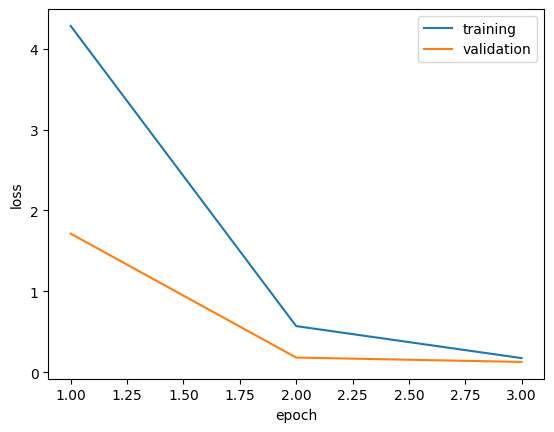

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1, epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Does Not look so good tbh but OK

## Evaluate model performance

We can see the final accuracy based on the test data, but typically we'll want to explore performance metrics in a little more depth. Let's plot a confusion matrix to see how well the model is predicting each class.

Generating predictions from validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


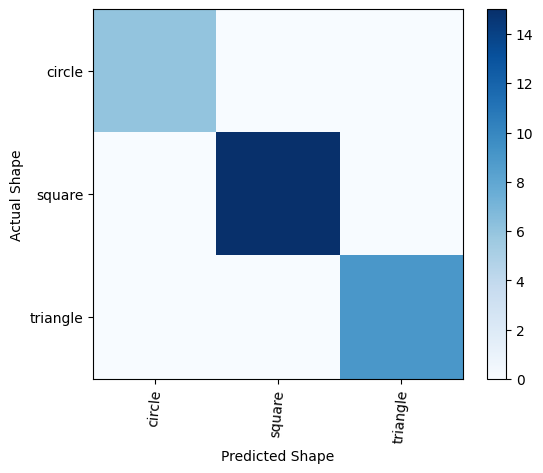

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print("Generating predictions from validation data...")
for x_test, y_test in validation_dataset.take(1):
    x_test: tf.Tensor; y_test: tf.Tensor
    x_test = np.array(x_test)
    y_test = np.array(y_test)

class_probabilities = model.predict(x_test)
predictions = np.argmax(class_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

Could be good enough ig

## Use the trained model

Now that we've trained the model, we can use it to predict the class of an image.

In [11]:
import numpy as np
from random import randint
import os
%matplotlib inline
from PIL import Image, ImageDraw
from random import randint

(224, 224, 3)


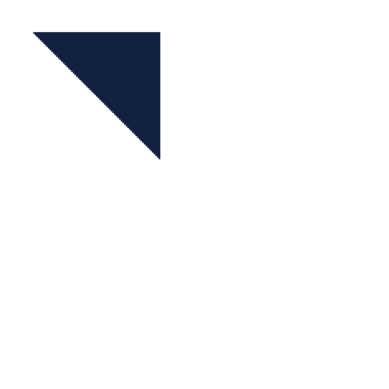

In [12]:
# Function to predict the class of an image
def predict_image(classifier: keras.models.Model, image: np.ndarray):
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

    # Normalize the image (divide by 255 to match training preprocessing)
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255

    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)

    # Find the class prediction with the highest predicted probability
    index = np.argmax(class_probabilities, axis=1)[0]
    return index

# Function to create a random image (square, circle, or triangle)
def create_image(size, shape):
    xy1 = randint(10, 40)
    xy2 = randint(60, 100)
    col = (randint(0, 200), randint(0, 200), randint(0, 200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)

    if shape == 'circle':
        draw.ellipse([(xy1, xy1), (xy2, xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1, xy1), (xy2, xy2), (xy2, xy1)], fill=col)
    else:  # square
        draw.rectangle([(xy1, xy1), (xy2, xy2)], fill=col)
    del draw

    return np.array(img)

# Load class names (for example, your shapes folder has class labels)
classnames = os.listdir(os.path.join('data', 'shapes'))
classnames.sort()

# Create a random test image from one of the class names
pretrained_size = (224,224)
img = create_image(pretrained_size, classnames[randint(0, len(classnames)-1)])

# Display the image
plt.axis('off')
plt.imshow(img)

print(img.shape)

In [13]:
# Load the model
# model = keras.models.load_model(modelFileName)

# Predict the class for the created image
class_idx = predict_image(model, img)

# Print the predicted class
print("Predicted class:", classnames[class_idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: triangle


If there's problems with shapes
* restart the kernel and run all (maybe some code was skipped or some caching issue)
* if in a pickle, replace Flatten layers with GlobalAveragePooling2D layers

  Replace the Flatten layer in your model with a GlobalAveragePooling2D layer, which reduces the spatial dimensions by computing the average across each feature map. This avoids the reshaping issues caused by Flatten.

```python
x = base_model.output
# x = Flatten()(x)
x = keras.layers.GlobalAveragePooling2D()(x)  # Replace Flatten with GAP
prediction_layer = Dense(len(classnames), activation='softmax')(x) 
model = keras.Model(inputs=base_model.input, outputs=prediction_layer)
```

## Learn More

* [Tensorflow Documentation](https://www.tensorflow.org/tutorials/images/transfer_learning)